# Lab3_NN. FI-21 Meloian

## Data prep + Baseline

In [1]:
import time, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, metrics, utils

# reproducibility
tf.keras.utils.set_random_seed(42)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<ipython-input-2-f27315ed2e1e>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(y_train[i]), fontsize=6)


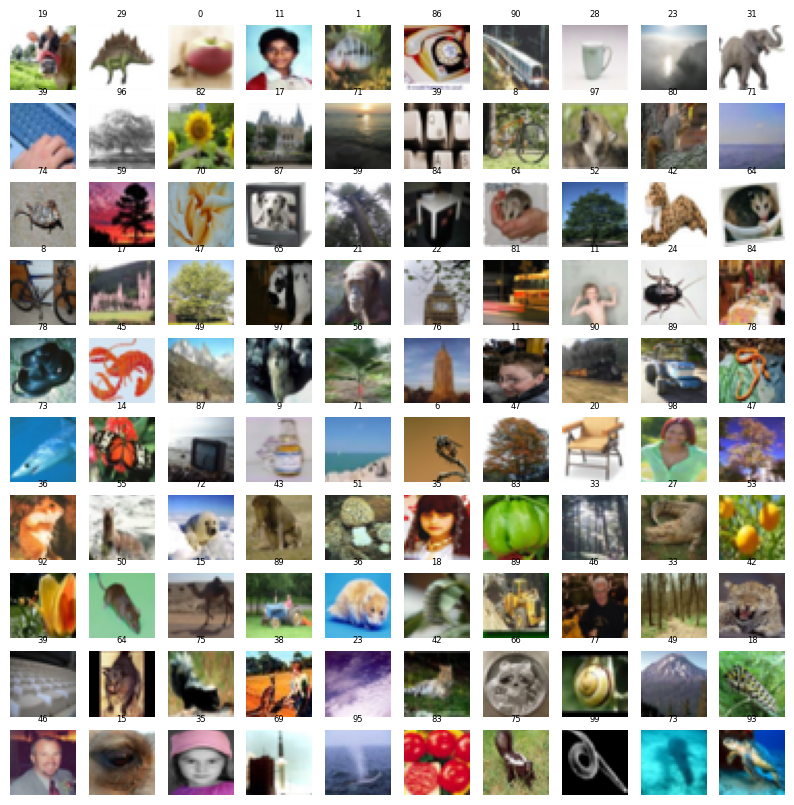

train: (50000, 32, 32, 3) (50000, 1)
test : (10000, 32, 32, 3) (10000, 1)


In [2]:
# 1. load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

# 2. preview first 100 images
plt.figure(figsize=(10,10))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(x_train[i])
    plt.title(int(y_train[i]), fontsize=6)
    plt.axis("off")
plt.show()

# 3. shapes
print("train:", x_train.shape, y_train.shape)
print("test :", x_test.shape,  y_test.shape)

In [3]:
x_train = x_train.astype("float32") / 255.0
x_test  = x_test .astype("float32") / 255.0

In [4]:
y_train = utils.to_categorical(y_train, 100)
y_test  = utils.to_categorical(y_test , 100)

In [5]:
x_valid, y_valid = x_train[40_000:], y_train[40_000:]
x_train, y_train = x_train[:40_000], y_train[:40_000]

print("x_train:", x_train.shape, "  x_valid:", x_valid.shape)

x_train: (40000, 32, 32, 3)   x_valid: (10000, 32, 32, 3)


In [6]:
def build_cnn(cfg: dict) -> tf.keras.Model:
    """
    Повертає скомпільовану модель згідно cfg.
    cfg keys (з промту):
        filters          - list[int], довжина = #Conv-блоків (min 3)
        activation       - str, activation після Conv
        use_dropout      - bool
        dropout_rate     - float
        use_batchnorm    - bool
        dense_units      - int, розмір Dense перед softmax
        extra_block      - bool, чи додати четвертий Conv з extra_filters
        extra_filters    - int, фільтри для extra_block
        optimizer        - str, 'adam'|'adamw'
        learning_rate    - float
    """
    f       = cfg.get("filters", [64,128,256])
    act     = cfg.get("activation", "relu")
    use_do  = cfg.get("use_dropout", True)
    do_rate = cfg.get("dropout_rate", 0.5)
    use_bn  = cfg.get("use_batchnorm", True)

    inputs = layers.Input((32,32,3))
    x = inputs
    for n_filters in f:
        x = layers.Conv2D(n_filters, 3, padding="same")(x)
        if use_bn: x = layers.BatchNormalization()(x)
        x = layers.Activation(act)(x)
        x = layers.Conv2D(n_filters, 3, padding="same")(x)
        if use_bn: x = layers.BatchNormalization()(x)
        x = layers.Activation(act)(x)
        x = layers.MaxPooling2D()(x)
        if use_do: x = layers.Dropout(do_rate)(x)

    # optional extra block
    if cfg.get("extra_block", False):
        ef = cfg.get("extra_filters", 256)
        x = layers.Conv2D(ef, 3, padding="same")(x)
        if use_bn: x = layers.BatchNormalization()(x)
        x = layers.Activation(act)(x)
        x = layers.MaxPooling2D()(x)
        if use_do: x = layers.Dropout(do_rate)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(cfg.get("dense_units", 512))(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.Activation(act)(x)
    if use_do: x = layers.Dropout(do_rate)(x)
    outputs = layers.Dense(100, activation="softmax")(x)

    model = models.Model(inputs, outputs, name=cfg.get("name", "cnn"))
    lr  = cfg.get("learning_rate", 1e-3)
    opt = {"adam": optimizers.Adam(lr),
           "adamw": optimizers.AdamW(lr)}[cfg.get("optimizer", "adam")]
    model.compile(opt,
                  loss = losses.CategoricalCrossentropy(),
                  metrics = ["accuracy", metrics.TopKCategoricalAccuracy(k=2,name="top2")])
    return model

In [7]:
def run_experiment(cfg: dict, name: str,
                   epochs: int = 20, batch: int = 128) -> dict:
    t0 = time.time()
    model = build_cnn({**cfg, "name": name})
    history = model.fit(
        x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=epochs, batch_size=batch, verbose=2)
    test_loss, test_acc, test_top2 = model.evaluate(x_test, y_test, verbose=0)
    dur = time.time() - t0
    result = {
        "name": name,
        "params": model.count_params(),
        "epochs": epochs,
        "time_s": round(dur,1),
        "test_loss": float(f"{test_loss:.4f}"),
        "test_acc":  float(f"{test_acc :.4f}"),
        "test_top2": float(f"{test_top2:.4f}")
    }
    results.append(result)
    return history

In [8]:
results = []

def plot_history(hist, title=""):
    plt.figure(figsize=(10,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.title(f"Loss {title}")
    plt.legend(); plt.grid(True)
    # accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history["accuracy"], label="train")
    plt.plot(hist.history["val_accuracy"], label="val")
    plt.title(f"Accuracy {title}")
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

**Чому саме така базова CNN?**

* Три каскадні Conv-блоки 64-128-256 забезпечують достатню глибину,
  але залишаються легкими для 32×32 зображень.
* Поєднання BatchNorm + ReLU стабілізує та прискорює навчання.
* Dropout 0.5 після Dense (512) мінімізує перенавчання, що помітно
  на прикладах із Lab 03 NN.pdf.

In [9]:
baseline_cfg = dict(
    filters=[64,128,256],
    activation="relu",
    use_dropout=True,
    dropout_rate=0.5,
    use_batchnorm=True,
    dense_units=512,
    optimizer="adam",
    learning_rate=1e-3)

hist_base = run_experiment(baseline_cfg, "Baseline")

Epoch 1/20
313/313 - 30s - 95ms/step - accuracy: 0.0792 - loss: 4.1628 - top2: 0.1367 - val_accuracy: 0.0335 - val_loss: 4.8069 - val_top2: 0.0650
Epoch 2/20
313/313 - 2s - 8ms/step - accuracy: 0.1783 - loss: 3.4185 - top2: 0.2800 - val_accuracy: 0.1863 - val_loss: 3.4027 - val_top2: 0.2899
Epoch 3/20
313/313 - 2s - 8ms/step - accuracy: 0.2549 - loss: 2.9832 - top2: 0.3763 - val_accuracy: 0.2602 - val_loss: 3.0292 - val_top2: 0.3827
Epoch 4/20
313/313 - 2s - 8ms/step - accuracy: 0.3149 - loss: 2.6623 - top2: 0.4469 - val_accuracy: 0.3223 - val_loss: 2.7151 - val_top2: 0.4515
Epoch 5/20
313/313 - 2s - 7ms/step - accuracy: 0.3627 - loss: 2.4396 - top2: 0.4999 - val_accuracy: 0.3392 - val_loss: 2.5722 - val_top2: 0.4753
Epoch 6/20
313/313 - 2s - 7ms/step - accuracy: 0.3947 - loss: 2.2836 - top2: 0.5386 - val_accuracy: 0.4324 - val_loss: 2.1282 - val_top2: 0.5740
Epoch 7/20
313/313 - 2s - 8ms/step - accuracy: 0.4228 - loss: 2.1520 - top2: 0.5663 - val_accuracy: 0.4186 - val_loss: 2.2054 - 

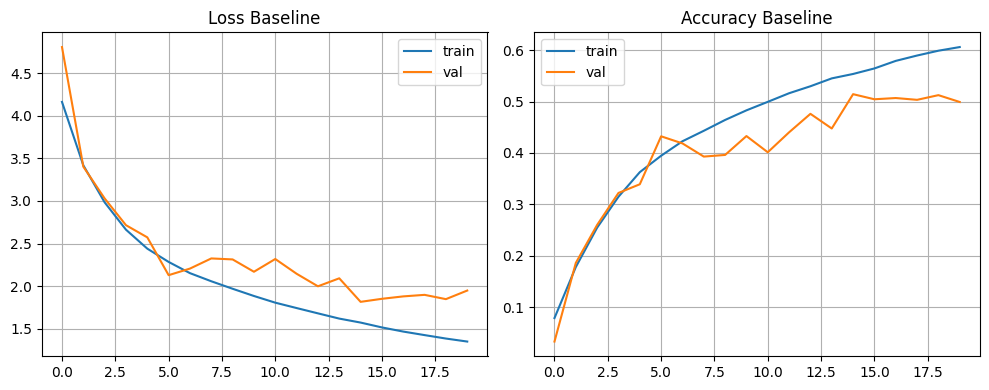

In [10]:
plot_history(hist_base, "Baseline")

In [11]:
# вивід архітектури текстом
build_cnn(baseline_cfg).summary()

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 3,300,004 (12.59 MB)

 Trainable params: 3,297,188 (12.58 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Серія експериментів
Мета — по одному фактору перевірити вплив архітектурних/регуляризаційних змін:

| Run | Що міняємо | Очікування |
|-----|------------|------------|
| **A** | Більше фільтрів → 96-192-384 | ↑ виразна здатність, можливо краща точність, ризик перенавчання |
| **B** | Менше фільтрів → 32-64-128 | ↓ параметрів, швидше, але ймовірно гірша якість |
| **C** | Активація **ELU** замість ReLU | Плавніша нелінійність, потенційно швидша сходимість |
| **D** | Вимкнути Dropout | Перевірка ролі регуляризації: очікуємо overfitting на валідації |
| **E** | BatchNorm після *кожного* Conv (прапорець use_batchnorm=True) | Перевірка впливу BN, коли він застосовується скрізь |
| **F** | Додаємо 4-й Conv-блок 256 фільтрів | Чи допоможе додаткова глибина/параметри |
| **G** | Dense 1024 + Dropout 0.3 | Більша «голова» мережі з м’якшою регуляризацією |
| **H** | Оптимізатор **AdamW**, lr = 1e-4 | Тест сучаснішого оптимізатора з weight-decay |

### Run A

In [12]:
cfg_A = dict(baseline_cfg, filters=[96, 192, 384])

In [13]:
hist_A = run_experiment(cfg_A, "Run_A_more_filters")

Epoch 1/20
313/313 - 25s - 81ms/step - accuracy: 0.0871 - loss: 4.1266 - top2: 0.1467 - val_accuracy: 0.0313 - val_loss: 5.0375 - val_top2: 0.0542
Epoch 2/20
313/313 - 3s - 10ms/step - accuracy: 0.2025 - loss: 3.2949 - top2: 0.3053 - val_accuracy: 0.1987 - val_loss: 3.3533 - val_top2: 0.3067
Epoch 3/20
313/313 - 3s - 10ms/step - accuracy: 0.2886 - loss: 2.8126 - top2: 0.4142 - val_accuracy: 0.2642 - val_loss: 3.0147 - val_top2: 0.3848
Epoch 4/20
313/313 - 3s - 10ms/step - accuracy: 0.3543 - loss: 2.4800 - top2: 0.4884 - val_accuracy: 0.3471 - val_loss: 2.5284 - val_top2: 0.4806
Epoch 5/20
313/313 - 3s - 10ms/step - accuracy: 0.4033 - loss: 2.2642 - top2: 0.5403 - val_accuracy: 0.3484 - val_loss: 2.5373 - val_top2: 0.4798
Epoch 6/20
313/313 - 3s - 10ms/step - accuracy: 0.4343 - loss: 2.1081 - top2: 0.5741 - val_accuracy: 0.4161 - val_loss: 2.2171 - val_top2: 0.5535
Epoch 7/20
313/313 - 3s - 11ms/step - accuracy: 0.4654 - loss: 1.9703 - top2: 0.6080 - val_accuracy: 0.4278 - val_loss: 2.2

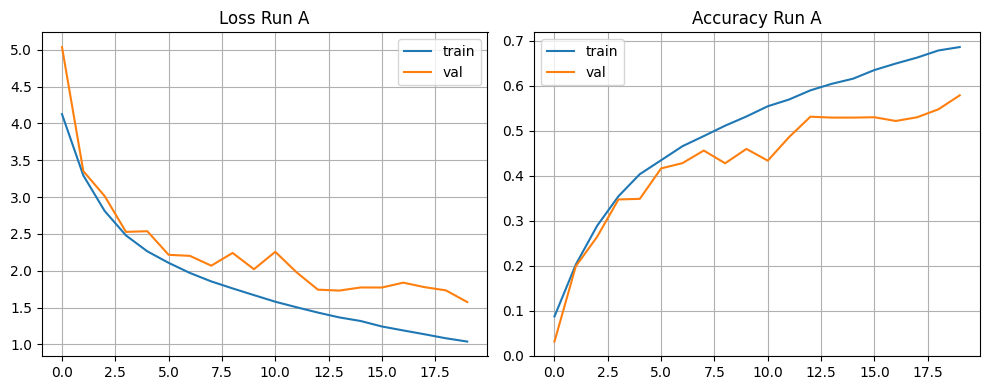

In [14]:
plot_history(hist_A, "Run A")

### Run B

In [15]:
cfg_B = dict(baseline_cfg, filters=[32, 64, 128])

In [16]:
hist_B = run_experiment(cfg_B, "Run_B_fewer_filters")

Epoch 1/20
313/313 - 22s - 70ms/step - accuracy: 0.0630 - loss: 4.3047 - top2: 0.1079 - val_accuracy: 0.0283 - val_loss: 5.1445 - val_top2: 0.0598
Epoch 2/20
313/313 - 2s - 6ms/step - accuracy: 0.1482 - loss: 3.6056 - top2: 0.2357 - val_accuracy: 0.1374 - val_loss: 3.7126 - val_top2: 0.2202
Epoch 3/20
313/313 - 2s - 6ms/step - accuracy: 0.2027 - loss: 3.2576 - top2: 0.3105 - val_accuracy: 0.2320 - val_loss: 3.1334 - val_top2: 0.3415
Epoch 4/20
313/313 - 2s - 6ms/step - accuracy: 0.2497 - loss: 3.0174 - top2: 0.3665 - val_accuracy: 0.2428 - val_loss: 3.0977 - val_top2: 0.3605
Epoch 5/20
313/313 - 2s - 6ms/step - accuracy: 0.2852 - loss: 2.8076 - top2: 0.4125 - val_accuracy: 0.2759 - val_loss: 2.9518 - val_top2: 0.3988
Epoch 6/20
313/313 - 2s - 6ms/step - accuracy: 0.3173 - loss: 2.6563 - top2: 0.4475 - val_accuracy: 0.3481 - val_loss: 2.5486 - val_top2: 0.4771
Epoch 7/20
313/313 - 2s - 6ms/step - accuracy: 0.3432 - loss: 2.5262 - top2: 0.4782 - val_accuracy: 0.3178 - val_loss: 2.6960 - 

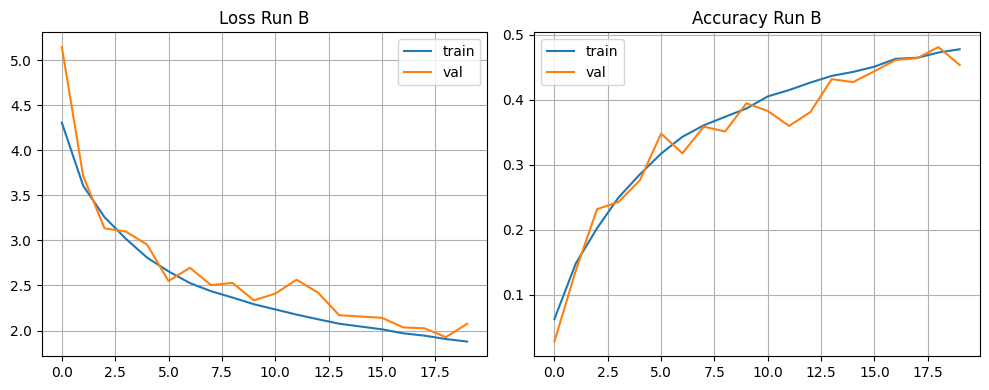

In [17]:
plot_history(hist_B, "Run B")

### Run C

In [18]:
cfg_C = dict(baseline_cfg, activation="elu")

In [19]:
hist_C = run_experiment(cfg_C, "Run_C_ELU")

Epoch 1/20
313/313 - 21s - 68ms/step - accuracy: 0.1072 - loss: 4.0535 - top2: 0.1757 - val_accuracy: 0.0332 - val_loss: 4.8737 - val_top2: 0.0690
Epoch 2/20
313/313 - 3s - 8ms/step - accuracy: 0.2151 - loss: 3.2599 - top2: 0.3219 - val_accuracy: 0.2477 - val_loss: 3.0837 - val_top2: 0.3645
Epoch 3/20
313/313 - 2s - 8ms/step - accuracy: 0.2928 - loss: 2.8363 - top2: 0.4165 - val_accuracy: 0.3023 - val_loss: 2.7839 - val_top2: 0.4324
Epoch 4/20
313/313 - 2s - 8ms/step - accuracy: 0.3433 - loss: 2.5736 - top2: 0.4767 - val_accuracy: 0.3673 - val_loss: 2.4870 - val_top2: 0.4992
Epoch 5/20
313/313 - 2s - 8ms/step - accuracy: 0.3779 - loss: 2.4083 - top2: 0.5137 - val_accuracy: 0.4082 - val_loss: 2.2783 - val_top2: 0.5427
Epoch 6/20
313/313 - 2s - 8ms/step - accuracy: 0.4048 - loss: 2.2796 - top2: 0.5439 - val_accuracy: 0.4213 - val_loss: 2.2336 - val_top2: 0.5589
Epoch 7/20
313/313 - 2s - 8ms/step - accuracy: 0.4281 - loss: 2.1781 - top2: 0.5660 - val_accuracy: 0.4433 - val_loss: 2.1258 - 

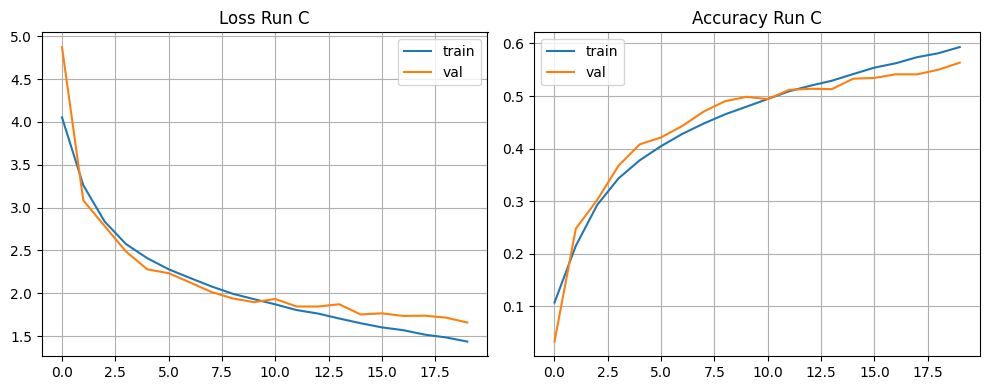

In [20]:
plot_history(hist_C, "Run C")

### Run D

In [21]:
cfg_D = dict(baseline_cfg, use_dropout=False)

In [22]:
hist_D = run_experiment(cfg_D, "Run_D_no_dropout")

Epoch 1/20
313/313 - 20s - 65ms/step - accuracy: 0.2509 - loss: 3.0987 - top2: 0.3585 - val_accuracy: 0.0591 - val_loss: 4.9457 - val_top2: 0.1001
Epoch 2/20
313/313 - 2s - 8ms/step - accuracy: 0.4590 - loss: 2.0552 - top2: 0.5928 - val_accuracy: 0.3174 - val_loss: 2.8508 - val_top2: 0.4351
Epoch 3/20
313/313 - 2s - 7ms/step - accuracy: 0.5951 - loss: 1.4998 - top2: 0.7258 - val_accuracy: 0.3774 - val_loss: 2.5730 - val_top2: 0.5009
Epoch 4/20
313/313 - 2s - 7ms/step - accuracy: 0.7268 - loss: 1.0306 - top2: 0.8339 - val_accuracy: 0.3547 - val_loss: 2.8141 - val_top2: 0.4782
Epoch 5/20
313/313 - 2s - 8ms/step - accuracy: 0.8389 - loss: 0.6386 - top2: 0.9192 - val_accuracy: 0.3330 - val_loss: 3.0980 - val_top2: 0.4524
Epoch 6/20
313/313 - 2s - 7ms/step - accuracy: 0.9151 - loss: 0.3672 - top2: 0.9687 - val_accuracy: 0.3704 - val_loss: 2.9050 - val_top2: 0.4894
Epoch 7/20
313/313 - 2s - 8ms/step - accuracy: 0.9536 - loss: 0.2071 - top2: 0.9896 - val_accuracy: 0.3824 - val_loss: 3.0828 - 

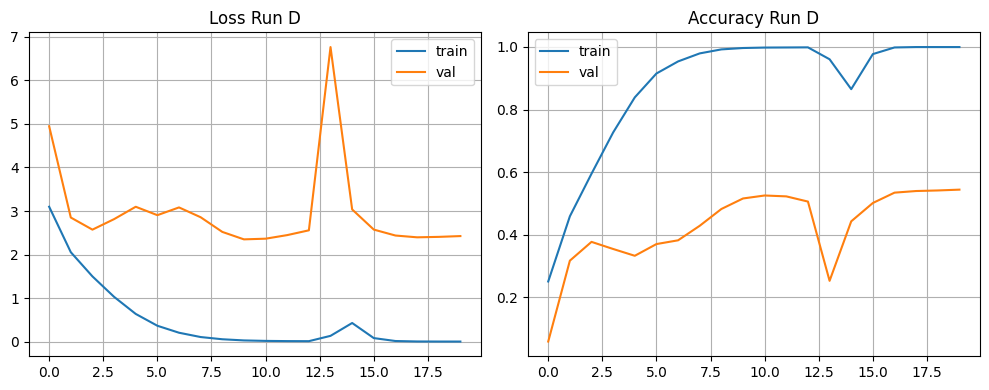

In [23]:
plot_history(hist_D, "Run D")

### Run E

In [24]:
cfg_E = dict(baseline_cfg, use_batchnorm=True)          # увімкнено BN скрізь

In [25]:
hist_E = run_experiment(cfg_E, "Run_E_batchnorm")

Epoch 1/20
313/313 - 22s - 69ms/step - accuracy: 0.0826 - loss: 4.1550 - top2: 0.1382 - val_accuracy: 0.0209 - val_loss: 5.1316 - val_top2: 0.0490
Epoch 2/20
313/313 - 2s - 8ms/step - accuracy: 0.1824 - loss: 3.3937 - top2: 0.2826 - val_accuracy: 0.1031 - val_loss: 4.1197 - val_top2: 0.1777
Epoch 3/20
313/313 - 2s - 8ms/step - accuracy: 0.2602 - loss: 2.9582 - top2: 0.3817 - val_accuracy: 0.2464 - val_loss: 3.1216 - val_top2: 0.3670
Epoch 4/20
313/313 - 2s - 8ms/step - accuracy: 0.3198 - loss: 2.6372 - top2: 0.4536 - val_accuracy: 0.3083 - val_loss: 2.8489 - val_top2: 0.4300
Epoch 5/20
313/313 - 2s - 8ms/step - accuracy: 0.3622 - loss: 2.4324 - top2: 0.4991 - val_accuracy: 0.3867 - val_loss: 2.3452 - val_top2: 0.5220
Epoch 6/20
313/313 - 2s - 8ms/step - accuracy: 0.3938 - loss: 2.2851 - top2: 0.5346 - val_accuracy: 0.3920 - val_loss: 2.3239 - val_top2: 0.5346
Epoch 7/20
313/313 - 2s - 8ms/step - accuracy: 0.4220 - loss: 2.1537 - top2: 0.5664 - val_accuracy: 0.4113 - val_loss: 2.2671 - 

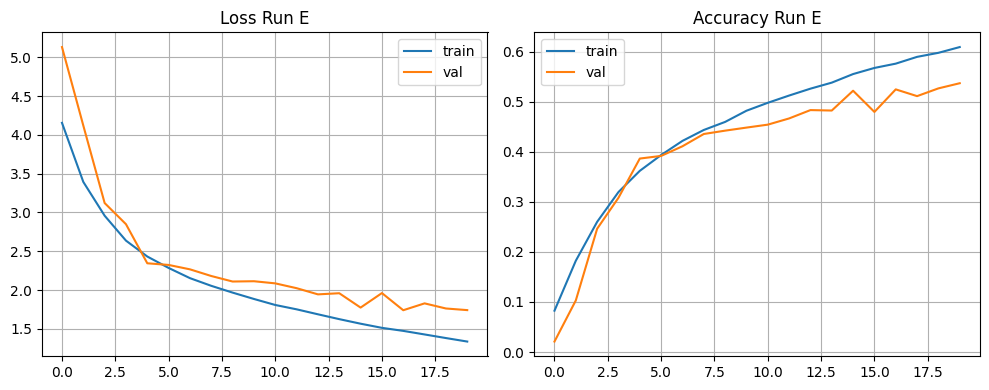

In [26]:
plot_history(hist_E, "Run E")

### Run G

In [27]:
cfg_G = dict(baseline_cfg, dense_units=1024, dropout_rate=0.3)

In [28]:
hist_G = run_experiment(cfg_G, "Run_G_big_dense")

Epoch 1/20
313/313 - 28s - 88ms/step - accuracy: 0.1573 - loss: 3.6620 - top2: 0.2410 - val_accuracy: 0.0466 - val_loss: 4.9718 - val_top2: 0.0903
Epoch 2/20
313/313 - 2s - 8ms/step - accuracy: 0.3084 - loss: 2.7546 - top2: 0.4331 - val_accuracy: 0.2783 - val_loss: 2.9478 - val_top2: 0.3985
Epoch 3/20
313/313 - 2s - 8ms/step - accuracy: 0.4058 - loss: 2.2555 - top2: 0.5456 - val_accuracy: 0.3862 - val_loss: 2.4445 - val_top2: 0.5152
Epoch 4/20
313/313 - 2s - 8ms/step - accuracy: 0.4768 - loss: 1.9398 - top2: 0.6185 - val_accuracy: 0.3965 - val_loss: 2.4319 - val_top2: 0.5323
Epoch 5/20
313/313 - 2s - 8ms/step - accuracy: 0.5316 - loss: 1.6991 - top2: 0.6742 - val_accuracy: 0.4459 - val_loss: 2.1855 - val_top2: 0.5776
Epoch 6/20
313/313 - 2s - 8ms/step - accuracy: 0.5767 - loss: 1.5074 - top2: 0.7183 - val_accuracy: 0.4578 - val_loss: 2.1162 - val_top2: 0.5948
Epoch 7/20
313/313 - 2s - 8ms/step - accuracy: 0.6182 - loss: 1.3333 - top2: 0.7569 - val_accuracy: 0.4461 - val_loss: 2.2621 - 

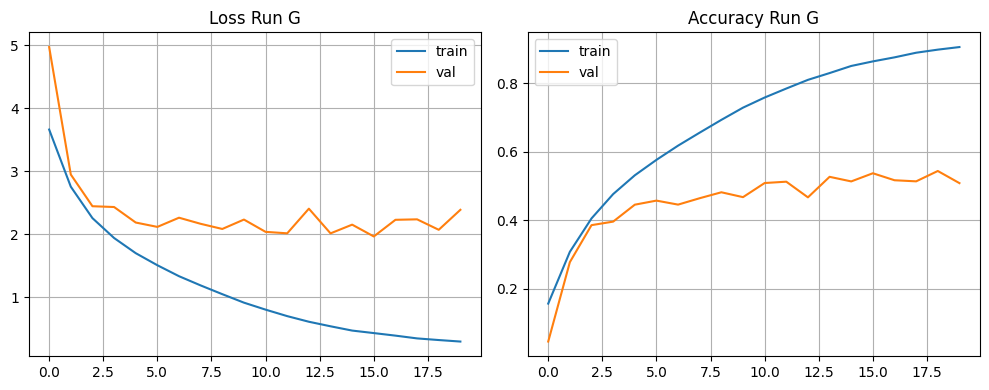

In [29]:
plot_history(hist_G, "Run G")

### Run H

In [30]:
cfg_H = dict(baseline_cfg, optimizer="adamw", learning_rate=1e-4)

In [31]:
hist_H = run_experiment(cfg_H, "Run_H_adamw")

Epoch 1/20
313/313 - 21s - 68ms/step - accuracy: 0.0248 - loss: 4.8515 - top2: 0.0451 - val_accuracy: 0.0088 - val_loss: 4.8074 - val_top2: 0.0193
Epoch 2/20
313/313 - 2s - 8ms/step - accuracy: 0.0516 - loss: 4.3486 - top2: 0.0932 - val_accuracy: 0.0353 - val_loss: 4.4255 - val_top2: 0.0691
Epoch 3/20
313/313 - 2s - 8ms/step - accuracy: 0.0801 - loss: 4.0965 - top2: 0.1371 - val_accuracy: 0.0595 - val_loss: 4.1693 - val_top2: 0.1065
Epoch 4/20
313/313 - 2s - 8ms/step - accuracy: 0.1026 - loss: 3.9063 - top2: 0.1728 - val_accuracy: 0.0888 - val_loss: 3.9936 - val_top2: 0.1449
Epoch 5/20
313/313 - 2s - 8ms/step - accuracy: 0.1248 - loss: 3.7604 - top2: 0.2012 - val_accuracy: 0.1074 - val_loss: 3.8712 - val_top2: 0.1744
Epoch 6/20
313/313 - 2s - 8ms/step - accuracy: 0.1468 - loss: 3.6302 - top2: 0.2313 - val_accuracy: 0.1200 - val_loss: 3.7972 - val_top2: 0.1948
Epoch 7/20
313/313 - 2s - 8ms/step - accuracy: 0.1689 - loss: 3.4997 - top2: 0.2609 - val_accuracy: 0.1454 - val_loss: 3.6459 - 

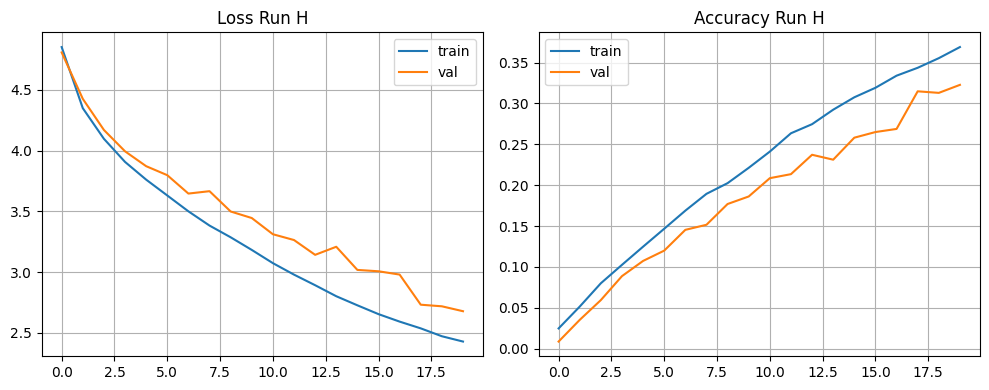

In [32]:
plot_history(hist_H, "Run H")

## Результати експериментів

,name,params,epochs,time_s,test_loss,test_acc,test_top2
1,Run_A_more_filters,5780164,20,90.0,1.5505,0.5894,0.7200
3,Run_C_ELU,3300004,20,70.3,1.6452,0.5593,0.6936
4,Run_D_no_dropout,3300004,20,68.1,2.4477,0.5508,0.6637
5,Run_E_batchnorm,3300004,20,69.7,1.7289,0.5349,0.6748
6,Run_G_big_dense,5450916,20,77.8,2.3697,0.5134,0.6427
0,Baseline,3300004,20,79.3,1.9274,0.5110,0.6383
2,Run_B_fewer_filters,1391236,20,59.1,2.0515,0.4580,0.5949
7,Run_H_adamw,3300004,20,69.2,2.6523,0.3312,0.4566


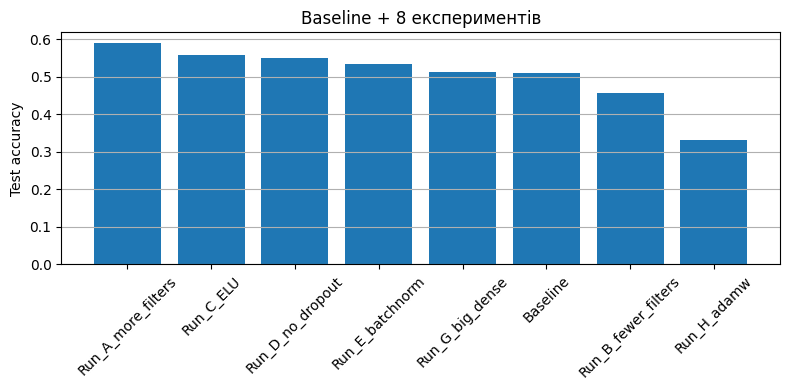

In [33]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.DataFrame(results)             # results наповнював run_experiment
df_sorted = df.sort_values("test_acc", ascending=False)
display(df_sorted)

plt.figure(figsize=(8,4))
plt.bar(df_sorted["name"], df_sorted["test_acc"])
plt.xticks(rotation=45)
plt.ylabel("Test accuracy")
plt.title("Baseline + 8 експериментів")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()